# Creating the Sentiment Variable

In [ ]:
# Loading in saved final dataset without going through previous data exploration
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load Data
df = pd.read_csv('/content/drive/My Drive/Masters Thesis/Colab notebook/clean_train.csv')
df.head()

,Unnamed: 0,Author_Handle,Date,X_Post,Reply_Count,Repost_Count,Like_Count,View_Count,Follower_Count,Verified_Status,Prediction,Confidence,Replying_to,date,post_text
0,22350,021Investment,2023-03-30 17:40:11,"As I pointed out yesterday, market is priced p...",0,0,0,48,22,0,negative,0.962576,False,2023-03-30 17:40:11,as i pointed out yesterday market is priced pe...
1,22588,021Investment,2023-04-04 15:39:16,People rushing into big tech for safety. But w...,0,0,1,26,22,0,neutral,0.535091,False,2023-04-04 15:39:16,people rushing into big tech for safety but wh...
2,25970,0Kiwii3,2023-06-02 20:20:37,"Will this be the day for #Sofi ? June14, where...",1,0,3,277,24,0,neutral,0.997390,False,2023-06-02 20:20:37,will this be the day for sofi june14 where th...
3,31281,0WLTrader,2023-10-05 23:44:30,The $USDJPY trade is very important for the #N...,0,0,0,67,262,0,neutral,0.993311,False,2023-10-05 23:44:30,the usdjpy trade is very important for the nik...
4,16498,0XGiorgos,2022-12-20 07:25:04,$BOJ also increased their bond purchases.... s...,0,1,1,139,151,1,negative,0.665027,False,2022-12-20 07:25:04,boj also increased their bond purchases seems ...


## Mapping Columns before creating the variables

In [ ]:
# Rename prediction to sentiment
df = df.rename(columns={'Prediction': 'Sentiment'})

# Map sentiment to numeric values
sentiment_map = {'positive': 1, 'neutral': 0.1, 'negative': -1}
df['Sentiment'] = df['Sentiment'].map(sentiment_map)

# Map Verified_Status to binary
df['Verified_Status'] = df['Verified_Status'].apply(lambda x: 1 if x == 1 else 0)

# Select relevant columns
columns_to_keep = [
    'Sentiment', 'Reply_Count', 'Repost_Count', 'Like_Count',
    'View_Count', 'Follower_Count', 'Verified_Status'
]
influence_df = df[columns_to_keep].copy()

In [ ]:
# Rename prediction to sentiment
df = df.rename(columns={'Prediction': 'Sentiment'})

# Select relevant columns
columns_to_keep = [
    'Sentiment', 'Date', 'X_Post', 'Reply_Count', 'Repost_Count', 'Like_Count',
    'View_Count', 'Follower_Count', 'Verified_Status'
]

influence_df = df[columns_to_keep].copy()

In [ ]:
df.shape

(32221, 15)

In [ ]:
influence_df.isna().any().any()

np.False_

In [ ]:
# Load val + test set
df_val = pd.read_csv('/content/drive/My Drive/Masters Thesis/Colab notebook/clean_val.csv')
df_test = pd.read_csv('/content/drive/My Drive/Masters Thesis/Colab notebook/clean_test.csv')


## Using Ratios

In [ ]:
from scipy.stats import boxcox
import numpy as np

engagement_cols = ['Like_Count', 'Repost_Count', 'Reply_Count'

# Dictionary to store lambda values for future use (validation/test sets)
boxcox_lambdas = {}

# Apply boxcox transformation
for col in engagement_cols:
    # Add 1 if zeros are present
    if (influence_df[col] <= 0).any():
        transformed, lam = boxcox(influence_df[col] + 1)
    else:
        transformed, lam = boxcox(influence_df[col])

    # Store transformed column and lambda
    influence_df[f'{col}_boxcox'] = transformed
    boxcox_lambdas[col] = lam

# Calculate global engagement totals
total_likes = influence_df['Like_Count_boxcox'].sum()
total_reposts = influence_df['Repost_Count_boxcox'].sum()
total_replies = influence_df['Reply_Count_boxcox'].sum()
total_engagement = total_likes + total_reposts + total_replies

# Calculate global weights
like_weight = total_likes / total_engagement
repost_weight = total_reposts / total_engagement
reply_weight = total_replies / total_engagement

print("Engagement Weights:")
print(f"Like: {like_weight:.3f}, Repost: {repost_weight:.3f}, Reply: {reply_weight:.3f}")


# Calculate engagement score
influence_df['Engagement_Score'] = (
    influence_df['Like_Count'] * like_weight +
    influence_df['Repost_Count'] * repost_weight +
    influence_df['Reply_Count'] * reply_weight
)

print("Sample Engagement Scores:")
print(influence_df[['Like_Count', 'Repost_Count', 'Reply_Count', 'Engagement_Score']].head(10))

Engagement Weights:
Like: 0.690, Repost: 0.137, Reply: 0.173
Sample Engagement Scores:
   Like_Count  Repost_Count  Reply_Count  Engagement_Score
0           0             0            0          0.000000
1           1             0            0          0.690357
2           3             0            1          2.244114
3           0             0            0          0.000000
4           1             1            0          0.826956
5           2             0            0          1.380714
6           1             0            0          0.690357
7           0             1            0          0.136599
8           0             0            0          0.000000
9          36            12            2         26.838125


Apply to val + test sets

In [ ]:
from scipy.special import boxcox1p

# Apply weights to validation set
df_val['Engagement_Score'] = (
    like_weight * df_val['Like_Count'] +
    repost_weight * df_val['Repost_Count'] +
    reply_weight * df_val['Reply_Count']
)

# Apply to test set
df_test['Engagement_Score'] = (
    like_weight * df_test['Like_Count'] +
    repost_weight * df_test['Repost_Count'] +
    reply_weight * df_test['Reply_Count']
)


In [ ]:
df_val.head()
df_val.shape

(7898, 16)

In [ ]:
df_test.head()
df_test.shape

(7516, 16)

## Random Forest

Class label encoding:
negative → 0
neutral → 1
positive → 2
Feature Importance (Impurity-Based):
Like_Count      0.483163
Reply_Count     0.283793
Repost_Count    0.233044
dtype: float64
Feature Importance Weights:
Like_Count      0.483163
Reply_Count     0.283793
Repost_Count    0.233044
dtype: float64
Permutation-Based Feature Weights:
Reply_Count     0.368178
Like_Count      0.367685
Repost_Count    0.264138
dtype: float64
Mean Permutation Importance Scores:
Reply_Count     0.041746
Like_Count      0.041690
Repost_Count    0.029949
dtype: float64
Standard Deviation of Importance:
Reply_Count     0.001750
Like_Count      0.001485
Repost_Count    0.001047
dtype: float64


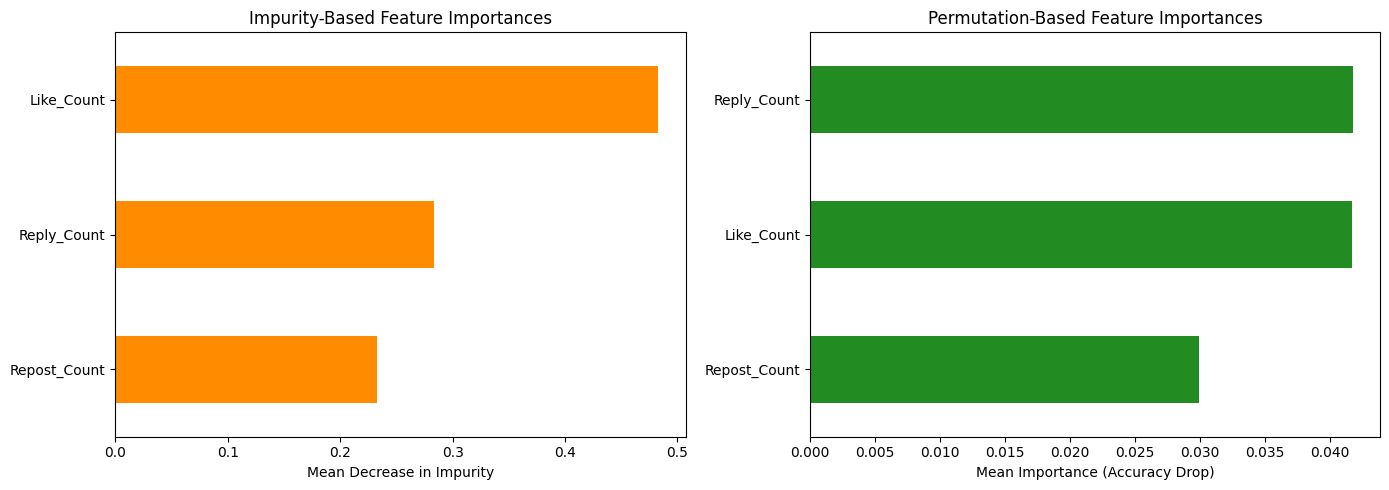

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

features = ['Like_Count', 'Repost_Count', 'Reply_Count']
X = influence_df[features]

# Encode sentiment if it's in text (e.g., 'positive', 'neutral', 'negative')
le = LabelEncoder()
y = le.fit_transform(influence_df['Sentiment'])

print("Class label encoding:")
for idx, label in enumerate(le.classes_):
    print(f"{label} → {idx}")

# -------------------------------
# Train RandomForest Classifier
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=2,
    random_state=42
)

rf.fit(X, y)

# --------------------
# IMPURITY IMPORTANCE
# --------------------
impurity_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importance (Impurity-Based):")
print(impurity_importance)

impurity_weights = impurity_importance / impurity_importance.sum()
print("Feature Importance Weights:")
print(impurity_weights)

# ---------------------
# PERMUTATION IMPORTANCE
# ---------------------
perm_result = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.Series(perm_result.importances_mean, index=features).sort_values(ascending=False)
perm_weights = perm_importance_df / perm_importance_df.sum()
print("Permutation-Based Feature Weights:")
print(perm_weights)

print("Mean Permutation Importance Scores:")
print(perm_importance_df.sort_values(ascending=False))

perm_importance_std = pd.Series(perm_result.importances_std, index=X.columns)
print("Standard Deviation of Importance:")
print(perm_importance_std.sort_values(ascending=False))

# ---------------------
# Plot Feature Importances
# ---------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

impurity_importance.sort_values().plot(kind='barh', ax=axes[0], color='darkorange')
axes[0].set_title("Impurity-Based Feature Importances")
axes[0].set_xlabel("Mean Decrease in Impurity")

perm_importance_df.sort_values().plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title("Permutation-Based Feature Importances")
axes[1].set_xlabel("Mean Importance (Accuracy Drop)")

plt.tight_layout()
plt.show()


In [ ]:
# engagement score impurity
influence_df['Engagement_Impurity'] = (
    impurity_weights['Like_Count'] * influence_df['Like_Count'] +
    impurity_weights['Repost_Count'] * influence_df['Repost_Count'] +
    impurity_weights['Reply_Count'] * influence_df['Reply_Count']
)

# engagement score permutation
influence_df['Engagement_permutation'] = (
    perm_weights['Like_Count'] * influence_df['Like_Count'] +
    perm_weights['Repost_Count'] * influence_df['Repost_Count'] +
    perm_weights['Reply_Count'] * influence_df['Reply_Count']
)

Apply to val and test set

In [ ]:
# --------------------
# IMPURITY WEIGHTS
# --------------------

# Compute engagement score on validation set
df_val['Engagement_Impurity'] = (
    impurity_weights['Like_Count'] * df_val['Like_Count'] +
    impurity_weights['Repost_Count'] * df_val['Repost_Count'] +
    impurity_weights['Reply_Count'] * df_val['Reply_Count']
)

# Compute engagement score on test set
df_test['Engagement_Impurity'] = (
    impurity_weights['Like_Count'] * df_test['Like_Count'] +
    impurity_weights['Repost_Count'] * df_test['Repost_Count'] +
    impurity_weights['Reply_Count'] * df_test['Reply_Count']
)

# ---------------------
# PERMUTATION IMPORTANCE
# ---------------------

# Compute engagement score on validation set
df_val['Engagement_permutation'] = (
    perm_weights['Like_Count'] * df_val['Like_Count'] +
    perm_weights['Repost_Count'] * df_val['Repost_Count'] +
    perm_weights['Reply_Count'] * df_val['Reply_Count']
)

# Compute engagement score on test set
df_test['Engagement_permutation'] = (
    perm_weights['Like_Count'] * df_test['Like_Count'] +
    perm_weights['Repost_Count'] * df_test['Repost_Count'] +
    perm_weights['Reply_Count'] * df_test['Reply_Count']
)

SHAP Feature Importance Weights:
Like_Count      0.323810
Repost_Count    0.429157
Reply_Count     0.247033
dtype: float64


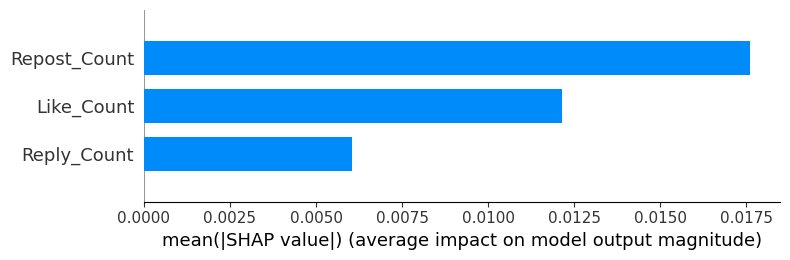

In [ ]:
import shap

# ----------------------
# SHAP ANALYSIS
# ----------------------

# Use a TreeExplainer for efficient SHAP on Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Get Mean absolute SHAP values per feature
mean_abs_shap = np.mean([np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))], axis=0)

# Create normalized weight vector
shap_weights = pd.Series(mean_abs_shap, index=features)
shap_weights = shap_weights / shap_weights.sum()

print("SHAP Feature Importance Weights:")
print(shap_weights)


# Plot feature importance:
shap.summary_plot(shap_values[0], X, plot_type="bar", class_names=le.classes_, show=True)


In [ ]:
# engagement score
influence_df['Engagement_SHAP'] = (
    shap_weights['Like_Count'] * influence_df['Like_Count'] +
    shap_weights['Repost_Count'] * influence_df['Repost_Count'] +
    shap_weights['Reply_Count'] * influence_df['Reply_Count']
)

Apply to val and test

In [ ]:
# Apply SHAP-based weights to compute engagement score in validation set
df_val['Engagement_SHAP'] = (
    shap_weights['Like_Count'] * df_val['Like_Count'] +
    shap_weights['Repost_Count'] * df_val['Repost_Count'] +
    shap_weights['Reply_Count'] * df_val['Reply_Count']
)

# Apply to test set
df_test['Engagement_SHAP'] = (
    shap_weights['Like_Count'] * df_test['Like_Count'] +
    shap_weights['Repost_Count'] * df_test['Repost_Count'] +
    shap_weights['Reply_Count'] * df_test['Reply_Count']
)

## Equal ratio

In [ ]:
# Apply equal weights
influence_df['Engagement_Equal'] = (
    (1/3) * influence_df['Like_Count'] +
    (1/3) * influence_df['Repost_Count'] +
    (1/3) * influence_df['Reply_Count']
)

apply on val and test

In [ ]:
# VAL
df_val['Engagement_Equal'] = (
    (1/3) * df_val['Like_Count'] +
    (1/3) * df_val['Repost_Count'] +
    (1/3) * df_val['Reply_Count']
)

# test
df_test['Engagement_Equal'] = (
    (1/3) * df_test['Like_Count'] +
    (1/3) * df_test['Repost_Count'] +
    (1/3) * df_test['Reply_Count']
)

In [ ]:
influence_df.head()

,Sentiment,Date,X_Post,Reply_Count,Repost_Count,Like_Count,View_Count,Follower_Count,Verified_Status,Like_Count_boxcox,Repost_Count_boxcox,Reply_Count_boxcox,Engagement_Score,Engagement_Impurity,Engagement_permutation,Engagement_SHAP,Engagement_Equal
0,negative,2023-03-30 17:40:11,"As I pointed out yesterday, market is priced p...",0,0,0,48,22,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,neutral,2023-04-04 15:39:16,People rushing into big tech for safety. But w...,0,0,1,26,22,0,0.539176,0.000000,0.000000,0.690357,0.483163,0.367685,0.323810,0.333333
2,neutral,2023-06-02 20:20:37,"Will this be the day for #Sofi ? June14, where...",1,0,3,277,24,0,0.858019,0.000000,0.317445,2.244114,1.733283,1.471232,1.218464,1.333333
3,neutral,2023-10-05 23:44:30,The $USDJPY trade is very important for the #N...,0,0,0,67,262,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,negative,2022-12-20 07:25:04,$BOJ also increased their bond purchases.... s...,0,1,1,139,151,1,0.539176,0.284847,0.000000,0.826956,0.716207,0.631822,0.752967,0.666667


# Creating SWISS

In [ ]:
# Map sentiment to numeric values
sentiment_map = {'positive': 1, 'neutral': 0.1, 'negative': -1}
influence_df['Sentiment_score'] = influence_df['Sentiment'].map(sentiment_map)

In [ ]:
influence_df.isna().any().any()

np.False_

In [ ]:
print(influence_df['Follower_Count'].min())
print((~np.isfinite(influence_df['Sentiment_score'])).sum())  # should be 0
print((~np.isfinite(influence_df['Follower_Count'])).sum())   # should be 0

0
0
0


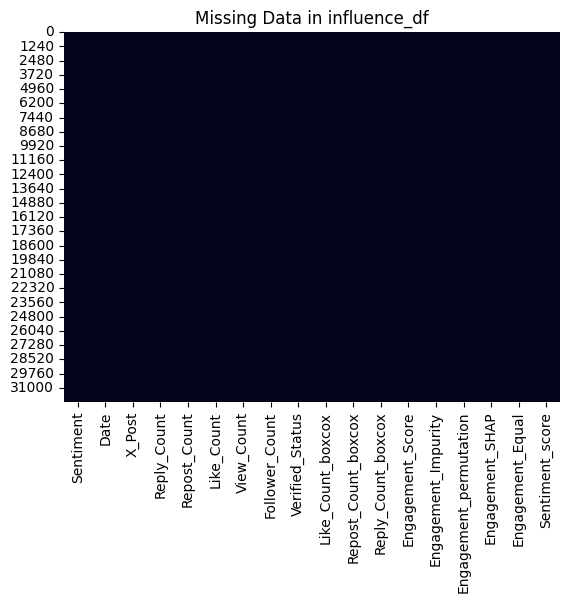

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(influence_df.isna(), cbar=False)
plt.title("Missing Data in influence_df")
plt.show()

In [ ]:
print(influence_df.columns.tolist())

['Sentiment', 'Date', 'X_Post', 'Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count', 'Follower_Count', 'Verified_Status', 'Like_Count_boxcox', 'Repost_Count_boxcox', 'Reply_Count_boxcox', 'Engagement_Score', 'Engagement_Impurity', 'Engagement_permutation', 'Engagement_SHAP', 'Engagement_Equal', 'Sentiment_score']


In [ ]:

# Define the engagement score columns
engagement_score_cols = {
    'SWIS_Equal': 'Engagement_Equal',
    'SWIS_Ratio': 'Engagement_Score',
    'SWIS_Impurity': 'Engagement_Impurity',
    'SWIS_perm': 'Engagement_permutation',
    'SWIS_SHAP': 'Engagement_SHAP'
}

# Function to adjust engagement: replace 0 with 1 to neutralize
def adjust_engagement(x):
    return x if x != 0 else 1

# Loop through all SWIS variants and compute scores
for swis_col, engagement_col in engagement_score_cols.items():
    adjusted_col = f'{engagement_col}_Adjusted'

    # Adjust engagement score to avoid zeroing out SWIS
    influence_df[adjusted_col] = influence_df[engagement_col].apply(adjust_engagement)

    # Compute SWIS
    influence_df[swis_col] = (
        influence_df['Sentiment_score'] *
        influence_df[adjusted_col] *
        np.log1p(influence_df['Follower_Count'])
    )

In [ ]:
influence_df.head(10)

,Sentiment,Date,X_Post,Reply_Count,Repost_Count,Like_Count,View_Count,Follower_Count,Verified_Status,Like_Count_boxcox,...,Engagement_Equal_Adjusted,SWIS_Equal,Engagement_Score_Adjusted,SWIS_Ratio,Engagement_Impurity_Adjusted,SWIS_Impurity,Engagement_permutation_Adjusted,SWIS_perm,Engagement_SHAP_Adjusted,SWIS_SHAP
0,negative,2023-03-30 17:40:11,"As I pointed out yesterday, market is priced p...",0,0,0,48,22,0,0.000000,...,1.000000,-3.135494,1.000000,-3.135494,1.000000,-3.135494,1.000000,-3.135494,1.000000,-3.135494
1,neutral,2023-04-04 15:39:16,People rushing into big tech for safety. But w...,0,0,1,26,22,0,0.539176,...,0.333333,0.104516,0.690357,0.216461,0.483163,0.151496,0.367685,0.115287,0.323810,0.101531
2,neutral,2023-06-02 20:20:37,"Will this be the day for #Sofi ? June14, where...",1,0,3,277,24,0,0.858019,...,1.333333,0.429183,2.244114,0.722353,1.733283,0.557922,1.471232,0.473571,1.218464,0.392208
3,neutral,2023-10-05 23:44:30,The $USDJPY trade is very important for the #N...,0,0,0,67,262,0,0.000000,...,1.000000,0.557215,1.000000,0.557215,1.000000,0.557215,1.000000,0.557215,1.000000,0.557215
4,negative,2022-12-20 07:25:04,$BOJ also increased their bond purchases.... s...,0,1,1,139,151,1,0.539176,...,0.666667,-3.349254,0.826956,-4.154529,0.716207,-3.598140,0.631822,-3.174200,0.752967,-3.782816
5,positive,2023-02-04 14:35:08,Official Trade Alert:\n4195/4200 4085/4080 @ 0...,0,0,2,698,2878,0,0.745608,...,0.666667,5.310132,1.380714,10.997658,0.966327,7.696985,0.735370,5.857366,0.647620,5.158426
6,negative,2023-03-10 03:38:53,"Can't say this enough, Stop loss must be respe...",0,0,1,606,2878,0,0.539176,...,0.333333,-2.655066,0.690357,-5.498829,0.483163,-3.848492,0.367685,-2.928683,0.323810,-2.579213
7,neutral,2022-05-03 11:46:06,#MicroStrategy one of the largest holders of #...,0,1,0,0,741,0,0.000000,...,0.333333,0.220312,0.136599,0.090283,0.233044,0.154027,0.264138,0.174578,0.429157,0.283645
8,positive,2022-10-11 12:32:58,If Unemployment claims was lesser than the for...,0,0,0,0,51,0,0.000000,...,1.000000,3.951244,1.000000,3.951244,1.000000,3.951244,1.000000,3.951244,1.000000,3.951244
9,positive,2022-03-30 05:58:12,It's coming $Yel $dYel #defi index like #SPX500,2,12,36,0,827,1,1.233942,...,16.666667,111.983553,26.838125,180.325714,20.757995,139.473240,17.142662,115.181769,17.301115,116.246419


In [ ]:
influence_df.to_excel("/content/drive/MyDrive/Masters Thesis/Colab notebook/preprocessed_train.xlsx")

doing the same for test + val

In [ ]:
# Map sentiment to numeric values
sentiment_map = {'positive': 1, 'neutral': 0.1, 'negative': -1}
df_val = df_val.rename(columns={'Prediction': 'Sentiment'})
df_test = df_test.rename(columns={'Prediction': 'Sentiment'})
df_val['Sentiment_score'] = df_val['Sentiment'].map(sentiment_map)
df_test['Sentiment_score'] = df_test['Sentiment'].map(sentiment_map)


# Define the engagement score columns
engagement_score_cols = {
    'SWIS_Equal': 'Engagement_Equal',
    'SWIS_Ratio': 'Engagement_Score',
    'SWIS_Impurity': 'Engagement_Impurity',
    'SWIS_perm': 'Engagement_permutation',
    'SWIS_SHAP': 'Engagement_SHAP'
}

# Helper function to replace 0 engagement with 1
def adjust_engagement(x):
    return x if x != 0 else 1

# Function to compute SWIS with adjustment
def compute_swis(df):
    for swis_col, engagement_col in engagement_score_cols.items():
        adjusted_col = f'{engagement_col}_Adjusted'
        df[adjusted_col] = df[engagement_col].apply(adjust_engagement)
        df[swis_col] = (
            df['Sentiment_score'] *
            df[adjusted_col] *
            np.log1p(df['Follower_Count'])
        )
    return df

# Apply to both validation and test sets
df_val = compute_swis(df_val)
df_test = compute_swis(df_test)

In [ ]:
df_val.to_excel("/content/drive/MyDrive/Masters Thesis/Colab notebook/preprocessed_val.xlsx")
df_test.to_excel("/content/drive/MyDrive/Masters Thesis/Colab notebook/preprocessed_test.xlsx")